# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision


## Homework 2 - Deep Neural Networks, Classifiers & Features
---

### <a style='color:red'> Due Date: 20.05.2021 </a>

### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
#### READ THIS CAREFULLY
* Submission only in **pairs**.
* **No handwritten submissions**.
* You can choose your working environment:
    * You can work in a `Jupyter Notebook`, locally with <a href="https://www.anaconda.com/distribution/">Anaconda</a> or online on <a href="https://colab.research.google.com/">Google Colab</a>
        * **Important**: Colab also supports running code on GPU, so if you don't have one, Colab is the way to go. To enable GPU on Colab, in the menu: `Runtime`$\rightarrow$ `Change Runtime Type` $\rightarrow$`GPU`.
    * You can work in a Python IDE such as <a href="https://www.jetbrains.com/pycharm/">PyCharm</a> or <a href="https://code.visualstudio.com/">Visual Studio Code</a>.
        * Both also allow opening/editing Jupyter Notebooks.
* You should submit two **separated** files:
    * A compressed `.zip` file, with the name: `ee046746_hw2_id1_id2.zip` which contains:
        * A folder named `code` with all the code files inside (`.py` or `.ipynb` ONLY!), and all the files required for the code to run (your own images/videos).
            * **The code should run both on CPU and GPU without manual modifications**, require no special preparation and run on every computer.
    * A report file (visualizations, discussing the results and answering the questions) in a `.pdf` format, with the name `ee046746_hw2_id1_id2.pdf`.
    * **DON'T** submit the SVHN dataset in your submission, we have a local copy of it.
    * **DON'T** submit the trained networks, but make sure to document every result you get.
        * Be precise, we expect on point answers.
        * No other file-types (`.docx`, `.html`, ...) will be accepted.
* Submission on the course website (Moodle).

### <img src="https://img.icons8.com/dusk/64/000000/python.png" style="height:50px;display:inline"> Python Libraries
---

* `numpy`
* `matplotlib`
* `pytorch` (and `torchvision`)
* `opencv` (or `scikit-image`)
* `scikit-learn`
* Anything else you need (`PIL`, `os`, `pandas`, `csv`, `json`,...)

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Tasks
---
* In all tasks, you should document your process and results in a report file (which will be saved as `.pdf`). 
* You can reference your code in the report file, but no need for actual code in this file, the code is submitted in a seprate folder as explained above.

#### Part 1 - Design and Build a CNN Classifier
---
In this part you are going to design a deep convolutional neural network to classify house number digits from the **The Street View House Numbers (SVHN)** Dataset. 

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

* 10 classes, 1 for each digit. Digit '0' has label 0, '1' has label 1,...
* 73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data.

<img src="http://ufldl.stanford.edu/housenumbers/32x32eg.png" style="height:250px">

1. Load the SVHN dataset with PyTorch using `torchvision.datasets.SVHN(root, split='train', transform=None, target_transform=None, download=True)` (<a href="https://pytorch.org/docs/stable/torchvision/datasets.html#svhn"> read more here</a>). Display 5 images from the train set.
2. Use the CNN from tutorials 3-4 (`CifarCnn()`) and train it on the SVHN dataset (**keep the architecture the same**) for the same number of **epochs** with the same learning rate (try to keep the batch size the same, but if you get memory errors, you can reduce it). What is the accuracy on the test set? What classes are most confusing for this model?
    * Your test accuracy from this section will be your **baseline** accuracy for sections 3-4.
3. Design a Convolutional Neural Network (CNN) to classify digits from the images. You can modify the network from section 2, but **you must get a better result than your baseline accuracy from section 2**.
    * Describe the chosen architecture, how many layers? What activations did you choose? What are the filter sizes? Did you use fully-connected layers (if you did, explain their sizes)?
    * What is the input dimension? What is the output dimension?
    * Calculate the number of parameters (weights) in the network.
4. Train the classifier (preferably on a **GPU - use Colab for this part** if you don't have a GPU).
    * Describe the the hyper-parameters of the model (batch size, epochs, learning rate....). How did you tune your model? Did you use a validation set to tune the model? (<a href="https://gist.github.com/MattKleinsmith/5226a94bad5dd12ed0b871aed98cb123">Separating to train/validation/test in PyTorch</a>)
    * What is the final accuracy on the test set?

In [1]:
# Install package
!pip install torchsummary

In [2]:
# %% Imports
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import SVHN
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [3]:
# %% Quesstion 1
# %% Load data

train_dataset = SVHN(root = './datasets',split='train',transform=None, target_transform=None, download=True)
test_dataset = SVHN(root = './datasets',split='test',transform=None, target_transform=None, download=True)

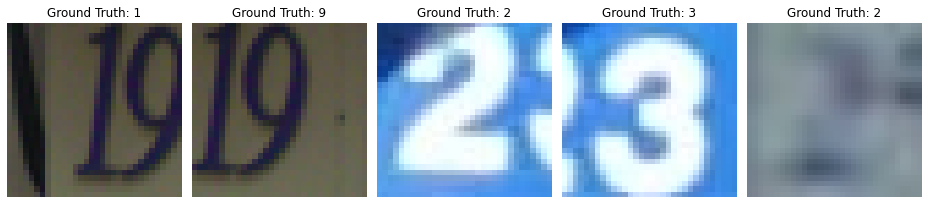

In [4]:
# %% Display 5 images from the train set.

fig = plt.figure(figsize=(13,9))
for i in range(5):
    ax=fig.add_subplot(1,5,i+1)
    ax.imshow(train_dataset[i][0],interpolation='none')
    ax.set_title("Ground Truth: {}".format(train_dataset[i][1]))
    ax.set_axis_off()
    plt.tight_layout()

In [5]:
# %% Quesstion 2
# %% Augmentations & Preprocessing, using the same augmenations as in the tutorial

transform_train=transforms.Compose([
        transforms.RandomCrop(32,padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010)),])

transform_test=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010)),])

classes = ('1','2','3','4','5','6','7','8','9','0')

# loading now with transforms applied
train_dataset = SVHN(root = './datasets',split='train',transform=transform_train, target_transform=None, download=True)
test_dataset = SVHN(root = './datasets',split='test',transform=transform_test, target_transform=None, download=True)

BATCH_SIZE = 128
learning_rate = 1e-4
epochs = 20

train_loader = DataLoader(dataset = train_dataset,batch_size = BATCH_SIZE,shuffle = True, num_workers=2)
test_loader = DataLoader(dataset = test_dataset,batch_size = BATCH_SIZE,shuffle = False,num_workers=2)


Using downloaded and verified file: ./datasets/train_32x32.mat
Using downloaded and verified file: ./datasets/test_32x32.mat


In [6]:
# %% Cifar CNN

class CifarCNN(nn.Module):
    """ CNN for the SVHN dataset copied from tutorial 3 -4  as requested"""
    def __init__(self):
        super(CifarCNN, self).__init__()

        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            # Conv Layer block 2
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2,stride=2),

        )

        self.fc_layer=nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512,10))
        
    def forward(self,x):
        """Perform forward."""
        # conv layers
        x=self.conv_layer(x)
        # flatten
        x=x.view(x.size(0),-1)
        # fc layer
        x=self.fc_layer(x)
        return x

In [7]:
# %% Optimizer setup 

# device - cpu or gpu?
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion=nn.CrossEntropyLoss()

# build our model and send it to the device
model=CifarCNN().to(device)# no need for parameters as we alredy defined them in the class

# optimizer - Adam
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [8]:
print('Model summary:')
summary(model, input_size=(3, 32, 32))

Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
             ReLU-11          [-1, 128, 16, 16]               0
        MaxPool2d-12            [-1, 128, 8, 8]               0
        Dropout2d-13            [-1, 128, 8, 8]               0
           Conv2d-14    

In [9]:
# function to calcualte accuracy of the model
def calculate_accuracy(model,dataloader,device):
    model.eval()# put in evaluation mode
    total_correct=0
    total_images=0
    confusion_matrix=np.zeros([10,10],int)
    with torch.no_grad():
        for data in dataloader:
            images,labels=data
            images=images.to(device)
            labels=labels.to(device)
            outputs=model(images)
            _,predicted=torch.max(outputs.data,1)
            total_images+=labels.size(0)
            total_correct+=(predicted==labels).sum().item()
            for i,l in enumerate(labels):
                confusion_matrix[l.item(),predicted[i].item()]+=1
    model_accuracy=total_correct/total_images*100
    return model_accuracy,confusion_matrix
            

In [24]:
# training loop
def TrainModel(model,epochs,network_type=0):
    for epoch in range(1,epochs+1):
        model.train()# put in training mode
        running_loss=0.0
        epoch_time=time.time()
        for i,data in enumerate(train_loader,0):
            # get the inputs
            inputs,labels=data# send them to device
            inputs=inputs.to(device)
            labels=labels.to(device)# forward + backward + optimize
            outputs=model(inputs)# forward pass
            loss=criterion(outputs,labels)# calculate the loss
            # always the same 3 steps
            optimizer.zero_grad()# zero the parameter gradients
            loss.backward()# backpropagation
            optimizer.step()# update parameters
            # print statistics
            running_loss+=loss.data.item()
        # Normalizing the loss by the total number of train batches
        running_loss/=len(train_loader)# Calculate training/test set accuracy of the existing model
        train_accuracy,_=calculate_accuracy(model,train_loader,device)

        
        if network_type == 2:
            test_accuracy,_=calculate_accuracy(model,valid_loader,device)
            log="Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Validation accuracy: {:.3f}% | ".format(epoch,running_loss,train_accuracy,test_accuracy)
        else:
            test_accuracy,_=calculate_accuracy(model,test_loader,device)
            log="Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch,running_loss,train_accuracy,test_accuracy)
        epoch_time=time.time()-epoch_time
        log+="Epoch Time: {:.2f} secs".format(epoch_time)
        print(log)
        # save model
        if epoch%10==0:
            print('==> Saving model ...')
            state={'net':model.state_dict(),'epoch':epoch,}
            if not os.path.isdir('checkpoints'):
                os.mkdir('checkpoints')
            if network_type == 0:
                torch.save(state,'./checkpoints/cifar_cnn_ckpt.pth')
            elif network_type == 1:
                torch.save(state,'./checkpoints/our_cnn_ckpt.pth')
            elif network_type == 2:
                torch.save(state,'./checkpoints/our_cnn_hyperparameter_tuning_ckpt.pth')
    print('==> Finished Training ...')




In [11]:
# %% Train model
TrainModel(model,epochs,network_type=0)

Epoch: 1 | Loss: 1.3428 | Training accuracy: 78.724% | Test accuracy: 77.774% | Epoch Time: 80.67 secs
Epoch: 2 | Loss: 0.5329 | Training accuracy: 86.673% | Test accuracy: 86.524% | Epoch Time: 80.61 secs
Epoch: 3 | Loss: 0.4086 | Training accuracy: 89.130% | Test accuracy: 89.448% | Epoch Time: 80.89 secs
Epoch: 4 | Loss: 0.3534 | Training accuracy: 89.817% | Test accuracy: 90.239% | Epoch Time: 82.10 secs
Epoch: 5 | Loss: 0.3163 | Training accuracy: 91.175% | Test accuracy: 90.527% | Epoch Time: 82.28 secs
Epoch: 6 | Loss: 0.2914 | Training accuracy: 92.412% | Test accuracy: 92.187% | Epoch Time: 81.70 secs
Epoch: 7 | Loss: 0.2723 | Training accuracy: 92.848% | Test accuracy: 93.132% | Epoch Time: 81.17 secs
Epoch: 8 | Loss: 0.2585 | Training accuracy: 93.324% | Test accuracy: 92.744% | Epoch Time: 80.13 secs
Epoch: 9 | Loss: 0.2458 | Training accuracy: 93.313% | Test accuracy: 93.020% | Epoch Time: 81.24 secs
Epoch: 10 | Loss: 0.2338 | Training accuracy: 93.745% | Test accuracy: 93

test accuracy: 94.503%


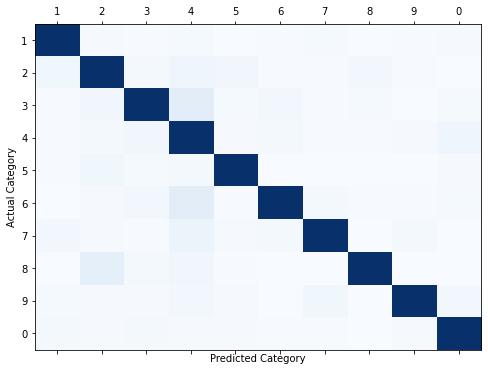

In [12]:
# load model, calculate accuracy and confusion matrix
model=CifarCNN().to(device)
state=torch.load('./checkpoints/cifar_cnn_ckpt.pth',map_location=device)
model.load_state_dict(state['net'])
test_accuracy,confusion_matrix=calculate_accuracy(model,test_loader,device)
print("test accuracy: {:.3f}%".format(test_accuracy))
# plot confusion matrix
fig,ax=plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix,aspect='auto',vmin=0,vmax=1000,cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10),classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10),classes)
plt.show()

In [13]:
# %% Quesstion 3
# %% Designing our network

class OurModel(nn.Module):
    """ CNN for the SVHN dataset copied from tutorial 3 -4  as requested"""
    def __init__(self):
        super(OurModel, self).__init__()

        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            # Conv Layer block 2
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2,stride=2),

        )

        self.fc_layer=nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8192,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512,10))
        
    def forward(self,x):
        """Perform forward."""
        # conv layers
        x=self.conv_layer(x)
        # flatten
        x=x.view(x.size(0),-1)
        # fc layer
        x=self.fc_layer(x)
        return x


In [14]:
# %% Optimizer setup 

# device - cpu or gpu?
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion=nn.CrossEntropyLoss()

# build our model and send it to the device
Our_Model=OurModel().to(device)# no need for parameters as we alredy defined them in the class

# optimizer - Adam
optimizer=torch.optim.Adam(Our_Model.parameters(),lr=learning_rate)



In [15]:
print('Our model summary:')
summary(Our_Model, input_size=(3, 32, 32))

Our model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
              ReLU-5          [-1, 128, 32, 32]               0
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Conv2d-7          [-1, 256, 16, 16]         295,168
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
           Conv2d-10          [-1, 256, 16, 16]         590,080
             ReLU-11          [-1, 256, 16, 16]               0
        MaxPool2d-12            [-1, 256, 8, 8]               0
        Dropout2d-13            [-1, 256, 8, 8]               0
           Conv2d-14

In [16]:
# %% Train our model
TrainModel(Our_Model,epochs,network_type=1)

Epoch: 1 | Loss: 1.1598 | Training accuracy: 82.761% | Test accuracy: 83.117% | Epoch Time: 121.55 secs
Epoch: 2 | Loss: 0.4390 | Training accuracy: 89.440% | Test accuracy: 89.232% | Epoch Time: 121.59 secs
Epoch: 3 | Loss: 0.3414 | Training accuracy: 91.335% | Test accuracy: 91.568% | Epoch Time: 121.53 secs
Epoch: 4 | Loss: 0.2996 | Training accuracy: 92.241% | Test accuracy: 92.390% | Epoch Time: 121.46 secs
Epoch: 5 | Loss: 0.2714 | Training accuracy: 92.928% | Test accuracy: 92.959% | Epoch Time: 121.29 secs
Epoch: 6 | Loss: 0.2522 | Training accuracy: 93.497% | Test accuracy: 93.393% | Epoch Time: 121.39 secs
Epoch: 7 | Loss: 0.2348 | Training accuracy: 93.841% | Test accuracy: 93.431% | Epoch Time: 121.26 secs
Epoch: 8 | Loss: 0.2227 | Training accuracy: 94.657% | Test accuracy: 94.150% | Epoch Time: 120.89 secs
Epoch: 9 | Loss: 0.2097 | Training accuracy: 95.020% | Test accuracy: 94.042% | Epoch Time: 121.32 secs
Epoch: 10 | Loss: 0.1972 | Training accuracy: 95.052% | Test acc

test accuracy: 95.187%


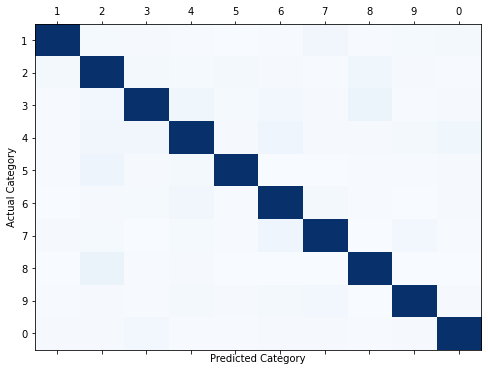

In [17]:
# load model, calculate accuracy and confusion matrix
Our_Model=OurModel().to(device)
state=torch.load('./checkpoints/our_cnn_ckpt.pth',map_location=device)
Our_Model.load_state_dict(state['net'])
test_accuracy,confusion_matrix=calculate_accuracy(Our_Model,test_loader,device)
print("test accuracy: {:.3f}%".format(test_accuracy))
# plot confusion matrix
fig,ax=plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix,aspect='auto',vmin=0,vmax=1000,cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10),classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10),classes)
plt.show()

In [18]:
# %% Quesstion 4
# %% Train validation test split:

def get_train_valid_loader(data_dir,
                           batch_size,
                           valid_size=0.2,
                           shuffle=True,
                           num_workers=1,
                           pin_memory=True):
    """
    Utility function for loading and returning train and valid 
    multi-process iterators over the MNIST dataset. A sample 
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize((0.1307,), (0.3081,))  # MNIST

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010)),])


    train_transform=transforms.Compose([
        transforms.RandomCrop(32,padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010)),])

    transform_test=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010)),])

    # load the dataset
    train_dataset = SVHN(root=data_dir, split='train',transform=transform_train, target_transform=None, download=True)
    valid_dataset = SVHN(root=data_dir, split='train',transform=valid_transform, target_transform=None, download=True)
    test_dataset = SVHN(root = data_dir,split='test',transform=transform_test, target_transform=None, download=True)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle == True:
        np.random.seed(3)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(train_dataset, 
                    batch_size=batch_size, sampler=train_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory)

    valid_loader = DataLoader(valid_dataset, 
                    batch_size=batch_size, sampler=valid_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory)

    test_loader = DataLoader(test_dataset,
                             batch_size = batch_size,shuffle = False,
                             num_workers=num_workers,pin_memory=pin_memory)


    return train_loader, valid_loader, test_loader


In [27]:
# %% Fine tuning network

BATCH_SIZE = 128
learning_rate = 1.5e-4
epochs = 30

train_loader, valid_loader, test_loader = get_train_valid_loader(data_dir='./datasets',batch_size = BATCH_SIZE)
# device - cpu or gpu?
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion=nn.CrossEntropyLoss()

# build our model and send it to the device
Our_Model2=OurModel().to(device)# no need for parameters as we alredy defined them in the class

# optimizer - Adam
optimizer=torch.optim.Adam(Our_Model2.parameters(),lr=learning_rate)


Using downloaded and verified file: ./datasets/train_32x32.mat
Using downloaded and verified file: ./datasets/train_32x32.mat
Using downloaded and verified file: ./datasets/test_32x32.mat


In [28]:
# %% Train model for validation
TrainModel(Our_Model2,epochs,network_type=2)

Epoch: 1 | Loss: 1.1234 | Training accuracy: 83.413% | Validation accuracy: 84.131% | Epoch Time: 99.65 secs
Epoch: 2 | Loss: 0.4383 | Training accuracy: 88.298% | Validation accuracy: 88.547% | Epoch Time: 99.31 secs
Epoch: 3 | Loss: 0.3479 | Training accuracy: 90.615% | Validation accuracy: 90.246% | Epoch Time: 99.10 secs
Epoch: 4 | Loss: 0.3023 | Training accuracy: 92.069% | Validation accuracy: 90.970% | Epoch Time: 99.46 secs
Epoch: 5 | Loss: 0.2727 | Training accuracy: 92.914% | Validation accuracy: 91.782% | Epoch Time: 99.23 secs
Epoch: 6 | Loss: 0.2564 | Training accuracy: 93.801% | Validation accuracy: 92.915% | Epoch Time: 99.66 secs
Epoch: 7 | Loss: 0.2366 | Training accuracy: 93.936% | Validation accuracy: 92.649% | Epoch Time: 99.66 secs
Epoch: 8 | Loss: 0.2215 | Training accuracy: 94.180% | Validation accuracy: 92.785% | Epoch Time: 100.05 secs
Epoch: 9 | Loss: 0.2140 | Training accuracy: 94.716% | Validation accuracy: 93.018% | Epoch Time: 99.54 secs
Epoch: 10 | Loss: 

In [30]:
# %% Train after validation on full training set

transform_train=transforms.Compose([
        transforms.RandomCrop(32,padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010)),])

transform_test=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010)),])

# loading now with transforms applied
train_dataset = SVHN(root = './datasets',split='train',transform=transform_train, target_transform=None, download=True)
test_dataset = SVHN(root = './datasets',split='test',transform=transform_test, target_transform=None, download=True)

train_loader = DataLoader(dataset = train_dataset,batch_size = BATCH_SIZE,shuffle = True, num_workers=2)
test_loader = DataLoader(dataset = test_dataset,batch_size = BATCH_SIZE,shuffle = False,num_workers=2)

# device - cpu or gpu?
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion=nn.CrossEntropyLoss()

# build our model and send it to the device
Our_Model2=OurModel().to(device)# no need for parameters as we alredy defined them in the class

# optimizer - Adam
optimizer=torch.optim.Adam(Our_Model2.parameters(),lr=learning_rate)

Using downloaded and verified file: ./datasets/train_32x32.mat
Using downloaded and verified file: ./datasets/test_32x32.mat


In [31]:
# Validation loss here has no meanining (as we train on the whole training set and the validation set is part of it)
TrainModel(Our_Model2,epochs,network_type=2)

Epoch: 1 | Loss: 1.1656 | Training accuracy: 81.480% | Validation accuracy: 81.646% | Epoch Time: 116.39 secs
Epoch: 2 | Loss: 0.4191 | Training accuracy: 89.852% | Validation accuracy: 90.376% | Epoch Time: 117.74 secs
Epoch: 3 | Loss: 0.3293 | Training accuracy: 90.491% | Validation accuracy: 90.936% | Epoch Time: 117.93 secs
Epoch: 4 | Loss: 0.2933 | Training accuracy: 92.451% | Validation accuracy: 93.461% | Epoch Time: 117.64 secs
Epoch: 5 | Loss: 0.2632 | Training accuracy: 92.788% | Validation accuracy: 93.338% | Epoch Time: 117.37 secs
Epoch: 6 | Loss: 0.2455 | Training accuracy: 93.689% | Validation accuracy: 93.809% | Epoch Time: 117.46 secs
Epoch: 7 | Loss: 0.2297 | Training accuracy: 93.954% | Validation accuracy: 94.608% | Epoch Time: 117.95 secs
Epoch: 8 | Loss: 0.2168 | Training accuracy: 94.040% | Validation accuracy: 93.966% | Epoch Time: 117.11 secs
Epoch: 9 | Loss: 0.2064 | Training accuracy: 94.906% | Validation accuracy: 94.990% | Epoch Time: 116.80 secs
Epoch: 10 

test accuracy: 95.237%


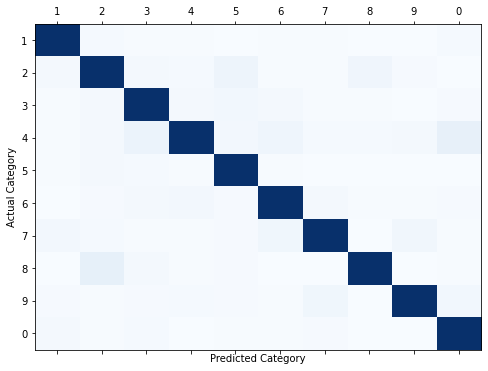

In [32]:
# load model, calculate accuracy and confusion matrix
Our_Model2=OurModel().to(device)
state=torch.load('./checkpoints/our_cnn_hyperparameter_tuning_ckpt.pth',map_location=device)
Our_Model2.load_state_dict(state['net'])
test_accuracy,confusion_matrix=calculate_accuracy(Our_Model2,test_loader,device)
print("test accuracy: {:.3f}%".format(test_accuracy))
# plot confusion matrix
fig,ax=plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix,aspect='auto',vmin=0,vmax=1000,cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10),classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10),classes)
plt.show()

#### Part 2 - Analyzing a Pre-trained CNN
---
In this part you are going to analyze a (large) pre-trained model. Pre-trained models are quite popular these days, as big companies can train really large models on large datasets (something that personal users can't do as they lack the sufficient hardware). These pre-trained models can be used to fine-tune on other/small datasets or used as components in other tasks (like using a pre-trained classifier for object detection).

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. 

You can use the following transform to normalize:

`normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`

<a href="https://pytorch.org/vision/stable/models.html">Read more here</a>

1. Load a pre-trained VGG16 with PyTorch using `torchvision.models.vgg16(pretrained=True, progress=True, **kwargs)` (<a href="https://pytorch.org/vision/stable/models.html#classification">read more here</a>). Don't forget to use the model in evaluation mode (`model.eval()`). 
2. Load the images in the `./birds` folder and display them.
3. Pre-process the images to fit VGG16's architecture. What steps did you take?
4. Feed the images (forward pass) to the model. What are the outputs?
5. Find an image of a bird/cat/dog on the internet, display it and feed it to network. What are the outputs?
6. Apply the following 3 transformations to create 3 *new* images from the image from step 5, and display them (`opencv` has functions for all):
    * One **geometric transformation** (rotation, scaling, translation, warping...).
    * One **color transformation** (thresholding, different color space, hue, saturation, brightness, contrast...).
    * One **filter** (any filter you want).
7. Feed the transformed images to network, what is the output? is it different than section 5?
8. For the first 3 filters in the *first layer* of VGG16, plot the filters, and then plot their response (their output) for the image from section 5 and the 3 images from section 6 (total of 4 input images). Explain what do you see.
    * Consult `ee046746_appndx_visualizing_cnn_filters.ipynb` to refresh your memory.
9. For each image in the `./dogs` and `./cats` folders, extract and save their feature vectors (create a numpy array or a torch tensor that contains the features for all samples) from a fully-connected layer (such as `FC7`) of the VGG16 model. Which layer did you pick? What is the size of the feature space?
    * You need to write a function that does the feed forward manually until the desired layer. See the example in `ee046746_appndx_visualizing_cnn_filters.ipynb`. 
10. Build a Support Vector Machine (SVM) classifier (hint: `sklearn.svm.LinearSVC`) to classify cats and dogs based on the features you extracted. Use the 20 images as train set, and choose 4 images (2 dogs, 2 cats) from the internet as test sets. You can choose a different classifer than SVM from the `scikit-learn` library, no need to explain how it works (but report the name of the algorithm you used). What are the results?

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com